### 简介

先看一个例子，某银行是否给用户放贷的判断规则集如下：  

```python
if 年龄==青年:
    if 有工作==是:
        if 信贷情况==非常好:
            放
        else:
            不放
    else:
        if 有自己的房子==是:
            if 信贷情况==一般:
                不放
            else:
                放
        else:
            if 信贷情况==非常好 or 信贷情况==好:
                放
            else:
                if 有工作==是:
                    放
                else:
                    不放
elif 年龄==中年:
    if 有自己的房子==是:
        放
    else:
        if 信贷情况==非常好 or 信贷情况==好:
            放
        else:
            if 有工作==是:
                放
            else:
                不放
elif 年龄==老年:
    if 有自己的房子==是:
        if 信贷情况==非常好 or 信贷情况==好:
            放
        else:
            不放
    else:
        if 信贷情况==非常好 or 信贷情况==好:
            if 有工作==是:
                放
            else:
                不放
        else:
            不放
if 有自己的房子==是:
    放
else:
    if 有工作==是:
        放
    else:
        不放
```

眼力好的同学立马会发现这代码写的有问题，比如只要`信贷情况==非常好`的用户都有放款，何必嵌到里面去？而且很多规则有冗余，为什么不重构一下呀？但现实情况是你可能真不敢随意乱动！因为指不定哪天项目经理又要新增加规则了，所以宁可让代码越来越冗余，越来越复杂，也不敢随意乱动之前的规则，乱动两条，可能会带来意想不到的灾难。简单总结一下这种复杂嵌套的`if else`规则可能存在的痛点：  

（1）规则可能不完备，存在某些匹配不上的情况；  

（2）规则之间存在冗余，多个`if else`情况其实是判断的同样的条件；  

（3）严重时，可能会出现矛盾的情况，即相同的条件，即有**放**，又有**不放**；  

（4）判断规则的优先级混乱，比如`信贷情况`因子可以优先考虑，因为只要它是`非常好`就可以放款，而不必先判断其它条件  

而决策树算法就能解决以上痛点，它能保证所有的规则**互斥且完备**，即用户的任意一种情况一定能匹配上一条规则，且该规则唯一，这样就能解决上面的痛点1~3，且规则判断的优先级也很不错，下面介绍决策树学习算法。

### 决策树学习
决策树算法可以从已标记的数据中自动学习出`if else`规则集，如下图（[图片来源>>>](https://www.cnblogs.com/jin-liang/p/9609144.html)），左边是收集的一系列判断是否打球的案例，包括4个特征outlook,temperature,Humidity,Wind,以及y标签是否打球，通过决策树学习后得到右边的决策树，**决策树的结构**如图所示，它由节点和有向边组成，而节点又分为两种：叶子节点和非叶子节点，非叶子节点主要用于对某一特征做判断，而它下面所链接的有向边表示该特征所满足的某条件，最终的叶子节点即表示实例的预测值(分类/回归)  


![avatar](./source/09_决策树学习.jpg)

决策树学习主要分为两个阶段，**决策树生成**和**决策树剪枝**，决策树生成阶段最重要便是**特征选择**，下面对相关概念做介绍：  

#### 1.特征选择  

特征选择用于选择对分类有用的特征，ID3和C4.5通常选择的准则是信息增益和信息增益比，下面对其作介绍并实现

##### 信息增益
首先介绍两个随机变量之间的互信息公式：  

$$
MI(Y,X)=H(Y)-H(Y|X)
$$  

这里$H(X)$表示$X$的熵，在最大熵模型那一节已做过介绍：  

$$
H(X)=-\sum_{i=1}^np_ilogp_i,这里p_i=P(X=x_i)
$$  

条件熵$H(Y|X)$表示在已知随机变量$X$的条件下，随机变量$Y$的不确定性：  

$$
H(Y|X)=\sum_{i=1}^np_iH(Y|X=x_i),这里p_i=P(X=x_i)
$$  

而信息增益就是$Y$取分类标签，$X$取某一特征时的互信息，它表示如果选择特征$X$对数据进行分割，可以使得分割后$Y$分布的熵降低多少，若降低的越多，说明分割每个子集的$Y$的分布越集中，则$X$对分类标签$Y$越有用，下面进行python实现：  

In [1]:
"""
定义计算熵的函数,封装到ml_models.utils
"""
import numpy as np
from collections import Counter
import math
def entropy(x,sample_weight=None):
    x=np.asarray(x)
    #x中元素个数
    x_num=len(x)
    #如果sample_weight为None设均设置一样
    if sample_weight is None:
        sample_weight=np.asarray([1.0]*x_num)
    x_counter={}
    weight_counter={}
    # 统计各x取值出现的次数以及其对应的sample_weight列表
    for index in range(0,x_num):
        x_value=x[index]
        if x_counter.get(x_value) is None:
            x_counter[x_value]=0
            weight_counter[x_value]=[]
        x_counter[x_value]+=1
        weight_counter[x_value].append(sample_weight[index])
    
    #计算熵
    ent=.0
    for key,value in x_counter.items():
        p_i=1.0*value*np.mean(weight_counter.get(key))/x_num
        ent+=-p_i*math.log(p_i)
    return ent

In [2]:
#测试
entropy([1,2])

0.6931471805599453

In [3]:
def cond_entropy(x, y,sample_weight=None):
    """
    计算条件熵:H(y|x)
    """
    x=np.asarray(x)
    y=np.asarray(y)
    # x中元素个数
    x_num = len(x)
    #如果sample_weight为None设均设置一样
    if sample_weight is None:
        sample_weight=np.asarray([1.0]*x_num)
    # 计算
    ent = .0
    for x_value in set(x):
        x_index=np.where(x==x_value)
        new_x=x[x_index]
        new_y=y[x_index]
        new_sample_weight=sample_weight[x_index]
        p_i=1.0*len(new_x)/x_num
        ent += p_i * entropy(new_y,new_sample_weight)
    return ent

In [4]:
#测试
cond_entropy([1,2],[1,2])

0.0

In [5]:
def muti_info(x, y,sample_weight=None):
    """
    互信息/信息增益:H(y)-H(y|x)
    """
    x_num=len(x)
    if sample_weight is None:
        sample_weight=np.asarray([1.0]*x_num)
    return entropy(y,sample_weight) - cond_entropy(x, y,sample_weight)

接下来，做一个测试，看特征的取值的个数对信息增益的影响

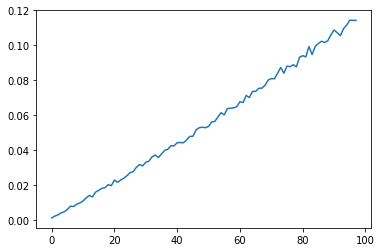

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#作epochs次测试
epochs=100
#x的取值的个数：2->class_num_x
class_num_x=100
#y标签类别数
class_num_y=2
#样本数量
num_samples=500
info_gains=[]
for _ in range(0,epochs):
    info_gain=[]
    for class_x in range(2,class_num_x):
        x=[]
        y=[]
        for _ in range(0,num_samples):
            x.append(random.randint(1,class_x))
            y.append(random.randint(1,class_num_y))
        info_gain.append(muti_info(x,y))
    info_gains.append(info_gain)
plt.plot(np.asarray(info_gains).mean(axis=0))

可以发现一个很有意思的现象，如果特征的取值的个数越多，越容易被选中，这比较好理解，假设一个极端情况，若对每一个实例特征$x$的取值都不同，则其$H(Y|X)$项为0，则$MI(X,Y)=H(Y)-H(Y|X)$将会取得最大值（$H(Y)$与$X$无关），这便是ID3算法的一个痛点，为了矫正这一问题，C4.5算法利用信息增益比作特征选择

##### 信息增益比
信息增益比其实就是对信息增益除以了一个$x$的熵：  

$$
\frac{MI(X,Y)}{H(X)}
$$

In [7]:
def info_gain_rate(x, y,sample_weight=None):
    """
    信息增益比
    """
    x_num=len(x)
    if sample_weight is None:
        sample_weight=np.asarray([1.0]*x_num)
    return 1.0 * muti_info(x, y,sample_weight) / (1e-12 + entropy(x,sample_weight))

接下来再作一次相同的测试：

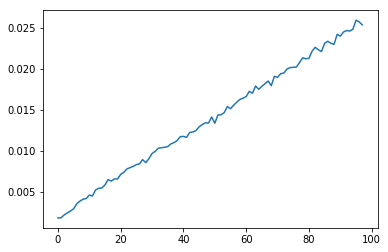

In [8]:
#作epochs次测试
epochs=100
#x的取值的个数：2->class_num_x
class_num_x=100
#y标签类别数
class_num_y=2
#样本数量
num_samples=500
info_gain_rates=[]
for _ in range(0,epochs):
    info_gain_rate_=[]
    for class_x in range(2,class_num_x):
        x=[]
        y=[]
        for _ in range(0,num_samples):
            x.append(random.randint(1,class_x))
            y.append(random.randint(1,class_num_y))
        info_gain_rate_.append(info_gain_rate(x,y))
    info_gain_rates.append(info_gain_rate_)
plt.plot(np.asarray(info_gain_rates).mean(axis=0))

虽然整体还是上升的趋势，当相比于信息增益已经缓解了很多，将它们画一起直观感受一下：  

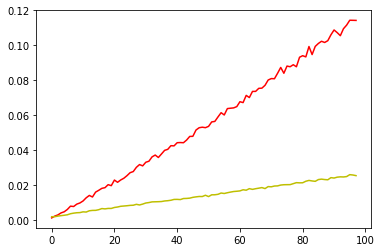

In [9]:
plt.plot(np.asarray(info_gains).mean(axis=0),'r')
plt.plot(np.asarray(info_gain_rates).mean(axis=0),'y')

#### 2.决策树生成
决策树的生成就是一个递归地调用特征选择的过程，首先从根节点开始，利用信息增益/信息增益比选择最佳的特征作为节点特征，由该特征的不同取值建立子节点，然后再对子节点调用以上方法，直到所有特征的信息增益/信息增益比均很小或者没有特征可以选择时停止，最后得到一颗决策树。接下来直接进行代码实现：  

In [10]:
import os
os.chdir('../')
from ml_models import utils
from ml_models.wrapper_models import DataBinWrapper
"""
ID3和C4.5决策树分类器的实现，放到ml_models.tree模块
"""
class DecisionTreeClassifier(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """

        def __init__(self, feature_index: int = None, target_distribute: dict = None, weight_distribute: dict = None,
                     children_nodes: dict = None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param target_distribute: 目标分布
            :param weight_distribute:权重分布
            :param children_nodes: 孩子节点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.target_distribute = target_distribute
            self.weight_distribute = weight_distribute
            self.children_nodes = children_nodes
            self.num_sample = num_sample

    def __init__(self, criterion='c4.5', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0, max_bins=10):
        """
        :param criterion:划分标准，包括id3,c4.5，默认为c4.5
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param min_impurity_decrease:打算划分一个内部结点时，只有当划分后不纯度(可以用criterion参数指定的度量来描述)减少值不小于该参数指定的值，才会对该结点进行划分，默认值为0
        """
        self.criterion = criterion
        if criterion == 'c4.5':
            self.criterion_func = utils.info_gain_rate
        else:
            self.criterion_func = utils.muti_info
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease

        self.root_node: self.Node = None
        self.sample_weight = None
        self.dbw = DataBinWrapper(max_bins=max_bins)

    def _build_tree(self, current_depth, current_node: Node, x, y, sample_weight):
        """
        递归进行特征选择，构建树
        :param x:
        :param y:
        :param sample_weight:
        :return:
        """
        rows, cols = x.shape
        # 计算y分布以及其权重分布
        target_distribute = {}
        weight_distribute = {}
        for index, tmp_value in enumerate(y):
            if tmp_value not in target_distribute:
                target_distribute[tmp_value] = 0.0
                weight_distribute[tmp_value] = []
            target_distribute[tmp_value] += 1.0
            weight_distribute[tmp_value].append(sample_weight[index])
        for key, value in target_distribute.items():
            target_distribute[key] = value / rows
            weight_distribute[key] = np.mean(weight_distribute[key])
        current_node.target_distribute = target_distribute
        current_node.weight_distribute = weight_distribute
        current_node.num_sample = rows
        # 判断停止切分的条件

        if len(target_distribute) <= 1:
            return

        if rows < self.min_samples_split:
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            return

        # 寻找最佳的特征
        best_index = None
        best_criterion_value = 0
        for index in range(0, cols):
            criterion_value = self.criterion_func(x[:, index], y)
            if criterion_value > best_criterion_value:
                best_criterion_value = criterion_value
                best_index = index

        # 如果criterion_value减少不够则停止
        if best_index is None:
            return
        if best_criterion_value <= self.min_impurity_decrease:
            return
        # 切分
        current_node.feature_index = best_index
        children_nodes = {}
        current_node.children_nodes = children_nodes
        selected_x = x[:, best_index]
        for item in set(selected_x):
            selected_index = np.where(selected_x == item)
            # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
            if len(selected_index[0]) < self.min_samples_leaf:
                continue
            child_node = self.Node()
            children_nodes[item] = child_node
            self._build_tree(current_depth + 1, child_node, x[selected_index], y[selected_index],
                             sample_weight[selected_index])

    def fit(self, x, y, sample_weight=None):
        # check sample_weight
        n_sample = x.shape[0]
        if sample_weight is None:
            self.sample_weight = np.asarray([1.0] * n_sample)
        else:
            self.sample_weight = sample_weight
        # check sample_weight
        if len(self.sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(self.sample_weight))

        # 构建空的根节点
        self.root_node = self.Node()

        # 对x分箱
        self.dbw.fit(x)

        # 递归构建树
        self._build_tree(1, self.root_node, self.dbw.transform(x), y, self.sample_weight)

    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x, class_num):
        if current_node.feature_index is None or current_node.children_nodes is None or len(
                current_node.children_nodes) == 0 or current_node.children_nodes.get(
            x[current_node.feature_index]) is None:
            result = []
            total_value = 0.0
            for index in range(0, class_num):
                value = current_node.target_distribute.get(index, 0) * current_node.weight_distribute.get(index, 1.0)
                result.append(value)
                total_value += value
            # 归一化
            for index in range(0, class_num):
                result[index] = result[index] / total_value
            return result
        else:
            return self._search_node(current_node.children_nodes.get(x[current_node.feature_index]), x, class_num)

    def predict_proba(self, x):
        # 计算结果概率分布
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        class_num = len(self.root_node.target_distribute)
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row], class_num))
        return np.asarray(results)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [11]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

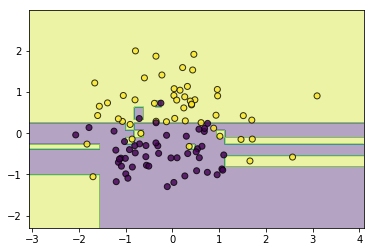

In [12]:
#训练查看效果
tree = DecisionTreeClassifier(max_bins=15)
tree.fit(data, target)
utils.plot_decision_function(data, target, tree)

可以发现，如果不对决策树施加一些限制，它会尝试创造很细碎的规则去使所有的训练样本正确分类，这无疑会使得模型过拟合，所以接下来需要对其进行减枝操作，避免其过拟合

#### 3.决策树剪枝
顾名思义，剪掉一些不必要的叶子节点，那么如何确定那些叶子节点需要去掉，哪些不需要去掉呢？这可以通过构建损失函数来量化，如果剪掉某一叶子结点后损失函数能减少，则进行剪枝操作，如果不能减少则不剪枝。一种简单的量化损失函数可以定义如下：  

$$
C_\alpha(T)=\sum_{t=1}^{\mid T\mid}N_tH_t(T)+\alpha\mid T\mid
$$

这里$\mid T \mid$表示树$T$的叶结点个数，$t$是树$\mid T \mid$的叶结点，该叶节点有$N_t$个样本点，其中$k$类样本点有$N_{tk}$个，$k=1,2,3,...,K$，$H_t(T)$为叶结点$t$上的经验熵，$\alpha\geq 0$为超参数，其中：  

$$
H_t(T)=-\sum_k\frac{N_{tk}}{N_t}log\frac{N_{tk}}{N_t}
$$  

该损失函数可以分为两部分，第一部分$\sum_{t=1}^{\mid T\mid}N_tH_t(T)$为经验损失，第二部分$\mid T \mid$为结构损失，$\alpha$为调节其平衡度的系数，如果$\alpha$越大则模型结构越简单，越不容易过拟合，接下来进行剪枝的代码实现：  

```python
    def _prune_node(self, current_node: Node, alpha):
        # 如果有子结点,先对子结点部分剪枝
        if current_node.children_nodes is not None and len(current_node.children_nodes) != 0:
            for child_node in current_node.children_nodes.values():
                self._prune_node(child_node, alpha)

        # 再尝试对当前结点剪枝
        if current_node.children_nodes is not None and len(current_node.children_nodes) != 0:
            # 避免跳层剪枝
            for child_node in current_node.children_nodes.values():
                # 当前剪枝的层必须是叶子结点的层
                if child_node.children_nodes is not None and len(child_node.children_nodes) > 0:
                    return
            # 计算剪枝前的损失值
            pre_prune_value = alpha * len(current_node.children_nodes)
            for child_node in current_node.children_nodes.values():
                for key, value in child_node.target_distribute.items():
                    pre_prune_value += -1 * child_node.num_sample * value * np.log(
                        value) * child_node.weight_distribute.get(key, 1.0)
            # 计算剪枝后的损失值
            after_prune_value = alpha
            for key, value in current_node.target_distribute.items():
                after_prune_value += -1 * current_node.num_sample * value * np.log(
                    value) * current_node.weight_distribute.get(key, 1.0)

            if after_prune_value <= pre_prune_value:
                # 剪枝操作
                current_node.children_nodes = None
                current_node.feature_index = None

    def prune(self, alpha=0.01):
        """
        决策树剪枝 C(T)+alpha*|T|
        :param alpha:
        :return:
        """
        # 递归剪枝
        self._prune_node(self.root_node, alpha)
```

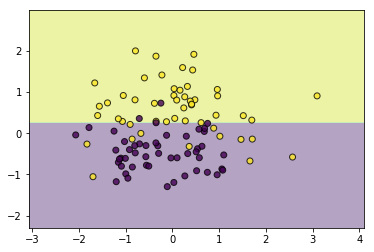

In [13]:
from ml_models.tree import DecisionTreeClassifier
#训练查看效果
tree = DecisionTreeClassifier(max_bins=15)
tree.fit(data, target)
tree.prune(alpha=1.5)
utils.plot_decision_function(data, target, tree)

通过探索$\alpha$，我们可以得到一个比较令人满意的剪枝结果，这样的剪枝方式通常又被称为**后剪枝**，即从一颗完整生成后的树开始剪枝，与其对应的还有**预剪枝**，即在训练过程中就对其进行剪枝操作，这通常需要另外构建一份**验证集**做支持，这里就不实现了，另外比较通常的做法是，通过一些参数来控制模型的复杂度，比如`max_depth`控制树的最大深度，`min_samples_leaf`控制叶子结点的最小样本数，`min_impurity_decrease`控制特征划分后的最小不纯度，`min_samples_split`控制结点划分的最小样本数，通过调节这些参数，同样可以达到剪枝的效果，比如下面通过控制叶结点的最小数量达到了和上面剪枝一样的效果：  

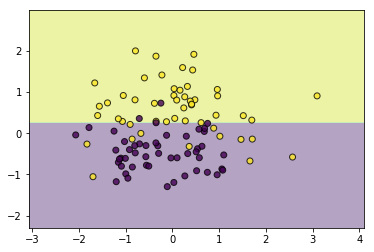

In [14]:
tree = DecisionTreeClassifier(max_bins=15,min_samples_leaf=3)
tree.fit(data, target)
utils.plot_decision_function(data, target, tree)

### 决策树另外一种理解：条件概率分布
决策树还可以看作是给定特征条件下类的条件概率分布：  

（1）训练时，决策树会将特征空间划分为大大小小互不相交的区域，而每个区域对应了一个类的概率分布；  

（2）预测时，落到某区域的样本点的类标签即是该区域对应概率最大的那个类